In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
!pip install dotenv
!pip install pinecone
!pip install pinecone-text
!pip install deepface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 3.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.1 MB/s eta 0:00:00


In [13]:
import os
import sys
from dotenv import load_dotenv, find_dotenv

class Utils:
    def __init__(self):
        pass

    def create_dlai_index_name(self, index_name):
        """Create a unique index name based on the Gemini API key (or part of it)."""
        gemini_key = ''
        if self.is_colab():
            from google.colab import userdata
            gemini_key = userdata.get("GEMINI_API_KEY")
        else:
            gemini_key = os.getenv("GEMINI_API_KEY")

        # Use a hashed or masked portion of the key if needed
        suffix = gemini_key[-12:].lower().replace("_", "-") if gemini_key else "no-key"
        return f'{index_name}-{suffix}'

    def is_colab(self):
        """Detect if the code is running in Google Colab."""
        return 'google.colab' in sys.modules

    def get_gemini_api_key(self):
        """Load Gemini API key from environment or .env file."""
        _ = load_dotenv(find_dotenv())
        return os.getenv("GEMINI_API_KEY")

    def get_pinecone_api_key(self):
        """Load Pinecone API key from environment or .env file."""
        _ = load_dotenv(find_dotenv())
        return os.getenv("PINECONE_API_KEY")

In [14]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
gemini_api_key = user_secrets.get_secret("GOOGLE_API_KEY")
pinecone_api_key = user_secrets.get_secret("PINECONE_API_KEY")

In [15]:
from deepface import DeepFace
from pinecone import Pinecone, ServerlessSpec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm


import contextlib
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

2025-09-06 13:17:34.229533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757164654.410480      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757164654.461083      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


25-09-06 13:17:46 - Directory /root/.deepface has been created
25-09-06 13:17:46 - Directory /root/.deepface/weights has been created


In [16]:
# get api key
utils = Utils()
PINECONE_API_KEY = utils.get_pinecone_api_key()

In [17]:
!wget -q --show-progress -O family_photos.zip "https://www.dropbox.com/scl/fi/yg0f2ynbzzd2q4nsweti5/family_photos.zip?rlkey=00oeuiii3jgapz2b1bfj0vzys&dl=0"

!unzip -q family_photos.zip

family_photos.zip   100%[===================>] 774.04K   879KB/s    in 0.9s    


In [18]:
def show_img(f):
  img = plt.imread(f)
  plt.figure(figsize=(4,3))
  plt.imshow(img)

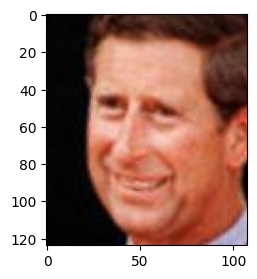

In [19]:
show_img("/kaggle/working/family/dad/P04409_face1.jpg")

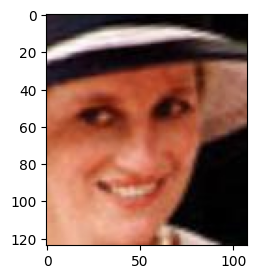

In [20]:
show_img("/kaggle/working/family/mom/P04409_face2.jpg")

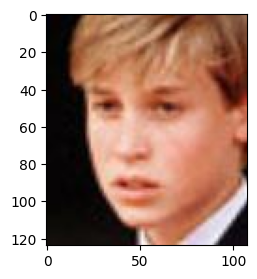

In [21]:
show_img("/kaggle/working/family/child/P04409_face0.jpg")

## Setup Pinecone

In [22]:
MODEL = "Facenet"
INDEX_NAME = utils.create_dlai_index_name('dl-ai')

pinecone = Pinecone(api_key=pinecone_api_key)

## Create Embeddings Using DeepFace

In [23]:
def generate_vectors():
  VECTOR_FILE = "./vectors.vec"

  with contextlib.suppress(FileNotFoundError):
    os.remove(VECTOR_FILE)
  with open(VECTOR_FILE, "w") as f:
    for person in ["mom", "dad", "child"]:
      files = glob.glob(f'family/{person}/*')
      for file in tqdm(files):
        try:
          embedding = DeepFace.represent(img_path=file, model_name=MODEL, enforce_detection=False)[0]['embedding']
          f.write(f'{person}:{os.path.basename(file)}:{embedding}\n')
        except (ValueError, UnboundLocalError, AttributeError) as e:
          print(e)

generate_vectors()

  0%|          | 0/78 [00:00<?, ?it/s]I0000 00:00:1757164899.470383      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757164899.471296      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


25-09-06 13:21:42 - 🔗 facenet_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5 to /root/.deepface/weights/facenet_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5

  0%|          | 0.00/92.2M [00:00<?, ?B/s]
  1%|          | 524k/92.2M [00:00<00:37, 2.42MB/s]
  2%|▏         | 2.10M/92.2M [00:00<00:11, 7.67MB/s]
  7%|▋         | 6.29M/92.2M [00:00<00:04, 19.5MB/s]
 11%|█▏        | 10.5M/92.2M [00:00<00:03, 26.3MB/s]
 16%|█▌        | 14.7M/92.2M [00:00<00:02, 30.5MB/s]
 20%|██        | 18.9M/92.2M [00:00<00:02, 33.2MB/s]
 25%|██▌       | 23.1M/92.2M [00:00<00:01, 35.0MB/s]
 30%|██▉       | 27.3M/92.2M [00:00<00:01, 36.4MB/s]
 34%|███▍      | 31.5M/92.2M [00:01<00:01, 37.2MB/s]
 39%|███▊      | 35.7M/92.2M [00:01<00:01, 37.8MB/s]
 43%|████▎     | 39.8M/92.2M [00:01<00:01, 38.3MB/s]
 48%|████▊     | 44.0M/92.2M [00:01<00:01, 37.2MB/s]
 52%|█████▏    | 48.2M/92.2M [00:01<00:01, 37.8MB/s]
 57%|█████▋    | 52.4M/92.2M [00:01<00:01, 38.2MB/s]
 61%|██████▏   | 56.6M/92.2M [00:01<00:00, 38.3MB/s]
 66%|██

In [24]:
!head -10 vectors.vec

mom:P11910_face4.jpg:[-0.6130889654159546, -0.5174542665481567, 1.0784233808517456, -1.8632705211639404, -0.30477339029312134, 0.3368951678276062, 0.42769983410835266, 1.9761230945587158, 0.04457244277000427, 0.7088512778282166, -0.17874521017074585, -0.230255126953125, -0.0700535699725151, 0.6033158302307129, -0.806454062461853, 0.014557421207427979, -0.09106692671775818, -0.7038707733154297, 0.3738987147808075, -1.8785134553909302, -0.12454550713300705, -0.898923933506012, -1.0961668491363525, 0.014973696321249008, -0.540764570236206, -0.5930852293968201, 0.8172235488891602, 1.3431533575057983, -0.8671157956123352, 0.40193626284599304, -0.6040472984313965, -0.04712183400988579, 1.1957809925079346, -1.0808930397033691, -0.0864710882306099, -0.7913864254951477, 0.2203899323940277, -0.23714473843574524, -0.7728613018989563, -0.5923519134521484, -0.06627463549375534, -0.7223072052001953, -0.6577737331390381, -0.15943700075149536, 0.06999115645885468, -1.4204521179199219, 0.01871020346879

## Plot the Data of Images

In [25]:
def gen_tsne_df(person, perplexity):
    vectors =[]
    with open('./vectors.vec', 'r') as f:
      for line in tqdm(f):
        p, orig_img, v = line.split(':')
        if person == p:
            vectors.append(eval(v))
    pca = PCA(n_components=8)
    tsne = TSNE(2, perplexity=perplexity, random_state = 0, n_iter=1000,
        verbose=0, metric='euclidean', learning_rate=75)
    print(f'transform {len(vectors)} vectors')
    pca_transform = pca.fit_transform(vectors)
    embeddings2d = tsne.fit_transform(pca_transform)
    return pd.DataFrame({'x':embeddings2d[:,0], 'y':embeddings2d[:,1]})

In [26]:
def plot_tsne(perplexity, model):
    (_, ax) = plt.subplots(figsize=(8,5))
    #plt.style.use('seaborn-whitegrid')
    plt.grid(color='#EAEAEB', linewidth=0.5)
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['left'].set_color('#2B2F30')
    ax.spines['bottom'].set_color('#2B2F30')
    colormap = {'dad':'#ee8933', 'child':'#4fad5b', 'mom':'#4c93db'}

    for person in colormap:
        embeddingsdf = gen_tsne_df(person, perplexity)
        ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.5, 
                   label=person, color=colormap[person])
    plt.title(f'Scatter plot of faces using {model}', fontsize=16, fontweight='bold', pad=20)
    plt.suptitle(f't-SNE [perplexity={perplexity}]', y=0.92, fontsize=13)
    plt.legend(loc='best', frameon=True)
    plt.show()

241it [00:00, 10260.33it/s]


transform 70 vectors


241it [00:00, 8216.17it/s]


transform 93 vectors


241it [00:00, 9261.15it/s]


transform 78 vectors


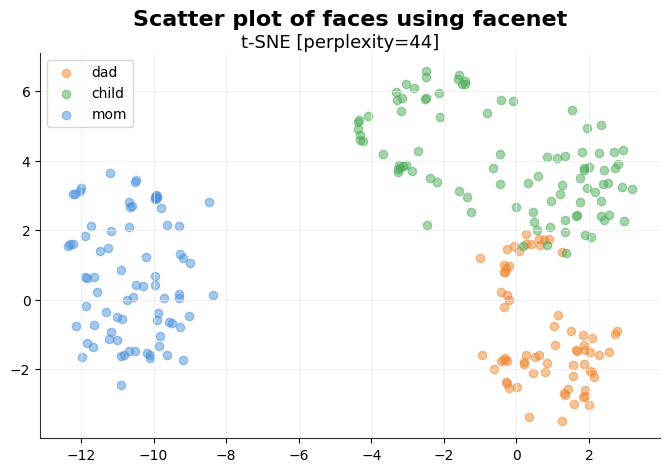

In [27]:
plot_tsne(44, 'facenet')

In [28]:
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
  pinecone.delete_index(INDEX_NAME)
pinecone.create_index(name=INDEX_NAME, dimension=128, metric='cosine',
  spec=ServerlessSpec(cloud='aws', region='us-east-1'))

index = pinecone.Index(INDEX_NAME)

In [29]:
def store_vectors():
  with open("vectors.vec", "r") as f:
    for line in tqdm(f):
        person, file, vec = line.split(':')
        index.upsert([(f'{person}-{file}', eval(vec), {"person":person, "file":file})])
store_vectors()

241it [00:54,  4.43it/s]


In [30]:
index.describe_index_stats()

{'dimension': 128,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 240}},
 'total_vector_count': 240,
 'vector_type': 'dense'}

## Calculate the Similarity Scores

In [31]:
def test(vec_groups, parent, child):
  index = pinecone.Index(INDEX_NAME)
  parent_vecs = vec_groups[parent]
  K = 10
  SAMPLE_SIZE = 10
  sum = 0
  for i in tqdm(range(0,SAMPLE_SIZE)):
    query_response = index.query(
      top_k=K,
      vector = parent_vecs[i],
      filter={
        "person": {"$eq": child}
      }
    )
    for row in query_response["matches"]:
      sum  = sum + row["score"]
  print(f'\n\n{parent} AVG: {sum / (SAMPLE_SIZE*K)}')

In [32]:
def compute_scores():
  index = pinecone.Index(INDEX_NAME)
  vec_groups = {"dad":[], "mom":[], "child":[]}
  with open("vectors.vec", "r") as f:
    for line in tqdm(f):
      person, file, vec = line.split(':')
      vec_groups[person].append(eval(vec))
  print(f"DAD {'-' * 20}")
  test(vec_groups, "dad", "child")
  print(f"MOM {'-' * 20}")
  test(vec_groups, "mom", "child")

compute_scores()

241it [00:00, 3545.98it/s]


DAD --------------------


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]




dad AVG: 0.45380457983
MOM --------------------


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]



mom AVG: 0.37805107104000013


## Check the Matching Images

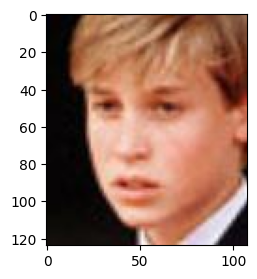

In [33]:
child_base = '/kaggle/working/family/child/P04409_face0.jpg'
show_img(child_base)

In [34]:
#Now find closest given we know dad is "most similar"
embedding = DeepFace.represent(img_path=child_base, model_name=MODEL)[0]['embedding']
print(embedding)

[-0.4940970242023468, 0.6079376935958862, -2.57029128074646, 0.7727699279785156, -0.23551352322101593, 0.6179576516151428, 0.3000572621822357, 0.361139178276062, -0.26880142092704773, 0.6094343662261963, -1.0579203367233276, -0.10773829370737076, 1.139426589012146, -0.9109013080596924, 0.7334669828414917, 0.17304475605487823, -0.19779255986213684, -2.5663764476776123, -1.5157160758972168, 0.2651379406452179, 0.8691071271896362, -0.9225581884384155, -1.3017550706863403, -1.7864807844161987, 0.23386256396770477, -0.3868902921676636, 0.29328545928001404, 0.19918343424797058, -0.898484468460083, 0.9762019515037537, 1.157231092453003, -0.5888954401016235, -0.18897461891174316, 0.29343366622924805, -0.6852222681045532, -0.8674348592758179, 0.45768821239471436, -0.6476346254348755, 0.48480457067489624, -2.2966690063476562, 0.23147180676460266, 3.1503500938415527, -1.3436293601989746, -0.3468707501888275, 0.04020886868238449, -0.7667941451072693, 0.8559718728065491, 1.2030527591705322, 0.67589

In [35]:
query_response = index.query(
      top_k=3,
      vector = embedding,
      filter={
        "person": {"$eq": "dad"}
      },
      include_metadata=True
)

In [36]:
print(query_response)

{'matches': [{'id': 'dad-P06337_face1.jpg',
              'metadata': {'file': 'P06337_face1.jpg', 'person': 'dad'},
              'score': 0.497545123,
              'values': []},
             {'id': 'dad-P11886_face3.jpg',
              'metadata': {'file': 'P11886_face3.jpg', 'person': 'dad'},
              'score': 0.402391,
              'values': []},
             {'id': 'dad-P06305_face0.jpg',
              'metadata': {'file': 'P06305_face0.jpg', 'person': 'dad'},
              'score': 0.358186364,
              'values': []}],
 'namespace': '',
 'usage': {'read_units': 1}}


In [37]:
photo = query_response['matches'][0]['metadata']['file']

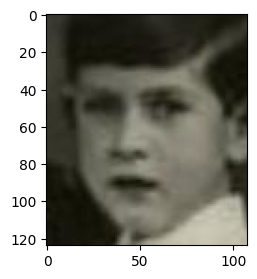

In [39]:
show_img(f'family/dad/{photo}')